In [1]:
import pandas as pd
import numpy as np
from csdi import CSDI_base
from utils import *
from training import train, evaluate
import warnings 
from preprocessing import SegmentStandardScaler
import datetime
warnings.filterwarnings('ignore')

/Users/artyomkraevskiy/opt/anaconda3/envs/DSPD/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Попробуем запуститься на синтетике

In [2]:
def create_synthetic_dataset(ticks, segments, start_date = '2020-01-01', share_of_misses = 0.2):
    # Simulate Wiener process trajectories

    df = pd.DataFrame()
    end_date = str(pd.to_datetime(start_date) + datetime.timedelta(days=ticks))
    df['date'] = pd.date_range(start_date, end_date, periods=ticks)
    for i in range(segments):
        df[f'seg_{i}'] = np.random.normal(0,1,ticks)

    return df

In [3]:
df = create_synthetic_dataset(450, 10, '2022-01-01')
df = transform_format(df, segments = df.columns[1:]).sort_values(['timestamp', 'segment']).reset_index(drop = True)

# Доля пропусков
share_of_misses = 0.2

df_train_nm = df[df.timestamp <= '2023-01-01'].reset_index(drop = True)
df_test_nm = df[df.timestamp > '2023-01-01'].reset_index(drop = True)


missing_values = np.random.choice(df.index.values, round(share_of_misses * len(df)))
df['target'] = np.where(df.index.isin(missing_values), np.nan, df['target'] )

df_train = df[df.timestamp <= '2023-01-01'].reset_index(drop = True)
df_test = df[df.timestamp > '2023-01-01'].reset_index(drop = True)

sc = SegmentStandardScaler(segments=df.segment.unique())
df_train = sc.fit_transform(df_train)

In [4]:
df_train['timestamp'] = df_train['timestamp'].astype(int)
df_test['timestamp'] = df_test['timestamp'].astype(int)

In [5]:
cust_df_train = Custom_Dataset(df_train)
cust_df_test = Custom_Dataset(df_test)

In [6]:
df_train_load = DataLoader(cust_df_train, batch_size=32, shuffle=1)

In [9]:
CSDI = CSDI_base(target_dim = 10, emb_time_dim=32, diffusion=32)

In [10]:
train(CSDI,
      df_train_load,
      epochs= 50,
      learning_rate= 0.005
      
      )

100%|██████████| 11/11 [00:10<00:00,  1.04it/s, avg_epoch_loss=0.141, epoch=49]


In [ ]:
# evaluate(CSDI, df_train, nsample=1, scaler=1, foldername=None)

In [11]:
import torch

def custom_imputer(model, df):

    df_final = pd.DataFrame()

    base_shape = df.gt_masks.shape
    transformed_shape = (base_shape[0], base_shape[2], base_shape[1])

    df_gt_mask_T = torch.tensor(df.gt_masks.reshape(transformed_shape), dtype=torch.float32)
    df_obs_data_T = torch.tensor(df.observed_values.reshape(transformed_shape), dtype=torch.float32)
    df_obs_mask_T = torch.tensor(df.observed_masks.reshape(transformed_shape), dtype=torch.float32)
    df_times = torch.tensor(df.observed_times, dtype=torch.float32)
 
    side_info = model.get_side_info(df_times, df_gt_mask_T)

    res = model.impute(df_obs_data_T, df_gt_mask_T, df_times, side_info, 1).reshape(base_shape)

    df_final = pd.concat((df_final, pd.DataFrame(res[0])))

    for i in range(1, len(res)):
        p = res[i]
        df_final = pd.concat((df_final, pd.DataFrame(p[-1]).T))
        
    return df_final

In [12]:
imputed_values = custom_imputer(CSDI, cust_df_test)

In [13]:
imputed_values = imputed_values.reset_index(drop = True)
imputed_values.columns = df_test.segment.unique()
imputed_values['date'] = df_test.timestamp.sort_values().unique()

In [14]:
imp_transf = transform_format(imputed_values, imputed_values.columns[:-1])

In [15]:
imp_transf.timestamp = imp_transf.timestamp.astype(int)

In [16]:
sc_transf = sc.inverse_transform(imp_transf)

In [17]:
df_all = df_test.merge(sc_transf.rename(columns = {'target' : 'target_imp'}), on = ['timestamp', 'segment'], how = 'left')

In [18]:
df_all['flag_imputed'] = np.where(df_all['target'].isna(), 1, 0)
df_all['target'] = np.where(df_all['target'].isna(), df_all.target_imp, df_all.target)

In [19]:
df_f = df_all[df_all.segment == 'seg_3']

In [20]:
df_f['timestamp'] = pd.to_datetime(df_f['timestamp'])

In [22]:
df_test_nm[df_test_nm.segment == 'seg_3']

timestamp segment    target
3   2023-01-01 19:30:36.080178172   seg_3  1.081982
13  2023-01-02 19:33:48.507795100   seg_3  0.035558
23  2023-01-03 19:37:00.935412024   seg_3  0.644495
33  2023-01-04 19:40:13.363028952   seg_3 -0.981415
43  2023-01-05 19:43:25.790645880   seg_3 -0.076137
..                            ...     ...       ...
803 2023-03-22 23:47:10.289532296   seg_3  0.550347
813 2023-03-23 23:50:22.717149216   seg_3 -1.938763
823 2023-03-24 23:53:35.144766144   seg_3 -0.737109
833 2023-03-25 23:56:47.572383072   seg_3 -2.221031
843 2023-03-27 00:00:00.000000000   seg_3  0.943298

[85 rows x 3 columns]

In [23]:
df_f[df_f.segment == 'seg_3']

timestamp segment    target  target_imp  flag_imputed
3   2023-01-01 19:30:36.080178172   seg_3  1.081982 -103.724663             0
13  2023-01-02 19:33:48.507795100   seg_3  0.400970    0.400970             1
23  2023-01-03 19:37:00.935412024   seg_3 -1.539924   -1.539924             1
33  2023-01-04 19:40:13.363028952   seg_3 -0.981415   -1.309623             0
43  2023-01-05 19:43:25.790645880   seg_3 -0.076137 -248.965088             0
..                            ...     ...       ...         ...           ...
803 2023-03-22 23:47:10.289532296   seg_3  0.550347    1.374293             0
813 2023-03-23 23:50:22.717149216   seg_3 -1.938763  282.712830             0
823 2023-03-24 23:53:35.144766144   seg_3 -0.737109 -207.141876             0
833 2023-03-25 23:56:47.572383072   seg_3 -2.221031  147.269791             0
843 2023-03-27 00:00:00.000000000   seg_3  0.943298  536.286072             0

[85 rows x 5 columns]

In [27]:
df_train.target[4]

nan

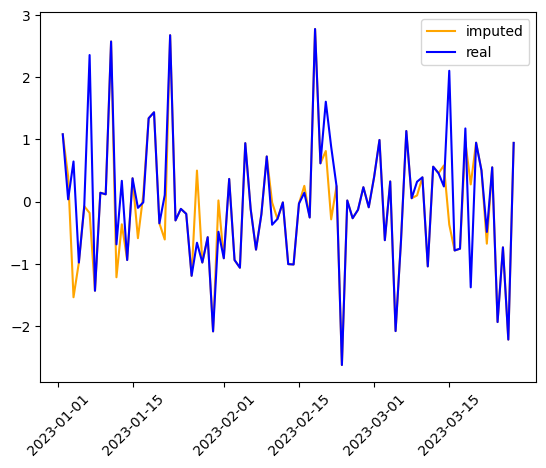

In [25]:
import matplotlib.pyplot as plt
plt.plot(df_f.timestamp, df_f.target, color = 'orange', label = 'imputed')
plt.plot(df_f.timestamp, df_test_nm[df_test_nm.segment == 'seg_3'].target, color = 'blue', label = 'real')
plt.xticks(rotation = 45)
plt.legend()
plt.show()